# Working with variance plane of cell-based coadds

This notebook is for understanding the behavior of the variance plane for cell-based coadds.

## Load in imports and data

Last working stack: `d_2024_08_27`

In [1]:
REPO = '/sdf/data/rubin/repo/main/'

from lsst.daf.butler import Butler
import lsst.afw.image as afwImage
from lsst.skymap import Index2D
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
import gc

%matplotlib inline

butler = Butler(REPO)
registry = butler.registry

# define image display backend
import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend('firefly')

# cell variance
import numpy.ma as ma

# mean weighted variance
from lsst.drp.tasks.assemble_cell_coadd import AssembleCellCoaddTask
import lsst.afw.math as afwMath

In [2]:
collection = 'u/mgorsuch/cell_coadds_tract_9813_d_2024_08_27/20240904T143002Z'

In [3]:
patch = 50

In [4]:
coadd = butler.get('deepCoaddCell', 
                     collections = collection, 
                     instrument = 'HSC', 
                     skymap = 'hsc_rings_cells_v1', 
                     tract = 9813, 
                     patch = patch,
                     band = 'i',)

In [5]:
cell_list_filled = list(coadd.cells.keys()) # skips empty cells

In [6]:
cell_list = []
cells_filled = [False] * coadd.grid.shape[0] * coadd.grid.shape[1]

index = 0
for i in range(coadd.grid.shape[0]):
    for j in range(coadd.grid.shape[1]):
        # Index2D axes are reverse of 2D list
        cell_list.append(Index2D(x=j,y=i))

        if Index2D(x=j,y=i) in cell_list_filled:
            cells_filled[index]=True

        index += 1

In [7]:
visits = []
for ref in butler.registry.queryDatasets('deepCoadd_directWarp', physical_filter='HSC-I', collections=collection, instrument='HSC', tract=9813, skymap = 'hsc_rings_cells_v1', patch=patch):
    visits.append(ref.dataId.get('visit'))
visits = np.unique(visits)

In [8]:
# arrange the number of inputs for each cell into a 2D grid:
x_cell_bin = np.arange(0,coadd.grid.shape[0]+1,1)
y_cell_bin = np.arange(0,coadd.grid.shape[1]+1,1)

inputs_list = np.zeros([coadd.grid.shape[0],coadd.grid.shape[1]])

# for cell in cell_list:
for index, cell in enumerate(cell_list):

    # check if the cell is filled, skip if not
    if not (cells_filled[index]):
        continue 
        
    num_cell_inputs = len(coadd.cells[cell].inputs)
    x_index = cell.x
    y_index = cell.y
        
    inputs_list[y_index][x_index] = num_cell_inputs

In [9]:
# create and configure stats control object as seen in assemble_cell_coadd task
statsCtrl = afwMath.StatisticsControl()
statsCtrl.setAndMask(afwImage.Mask.getPlaneBitMask(("BAD", "NO_DATA", "SAT"))) # use default PlaneBitMasks from task
statsCtrl.setNanSafe(True)

## Cell Variance Distribution

### Plot 2D histogram of variance 

While each cell has an entire variance plane, a single point value is taken to represent an entire cell. Either the mean of median variance of a cell is used.

Care to mask inf/nan values needs to be taken when working with the variance plane.

In [10]:
mask_mean_var_list = ma.masked_invalid(np.empty([coadd.grid.shape[0],coadd.grid.shape[1]]))
mask_median_var_list = ma.masked_invalid(np.empty([coadd.grid.shape[0],coadd.grid.shape[1]]))

for index, cell in enumerate(cell_list):

    # check if the cell is filled, skip if not
    if not (cells_filled[index]):
        continue 
    
    var_array = coadd.cells[cell].inner.variance.array

    x_index = cell.x
    y_index = cell.y

    # mask cells where entire variance plane is inf/-inf
    if (len(var_array[np.isfinite(var_array)]) == 0):
        # any variance value here will be masked, so just pick the first one
        mask_mean_var_list[y_index][x_index] = var_array[0][0]
        mask_median_var_list[y_index][x_index] = var_array[0][0]
        continue
    
    mean_var = np.mean(var_array[np.isfinite(var_array)])
    median_var = np.median(var_array[np.isfinite(var_array)])

    mask_mean_var_list[y_index][x_index] = mean_var
    mask_median_var_list[y_index][x_index] = median_var

mask_mean_var_list = ma.masked_invalid(mask_mean_var_list)
mask_median_var_list = ma.masked_invalid(mask_mean_var_list)

mask_mean_var_list = ma.masked_where(inputs_list == 0.0, mask_mean_var_list)
mask_median_var_list = ma.masked_where(inputs_list == 0.0, mask_median_var_list)

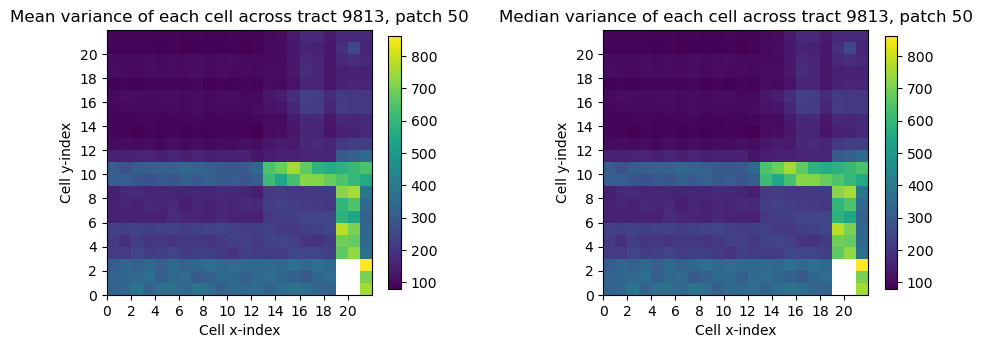

In [11]:
fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(9,9))
plt.tight_layout()
plt.subplots_adjust(wspace=0.5)

input_distrib = ax1.pcolormesh(mask_mean_var_list, 
                               shading='auto', 
                               vmin=mask_mean_var_list.min(), 
                               vmax=mask_mean_var_list.max())
ax1.set_title(f"Mean variance of each cell across tract 9813, patch {patch}")
ax1.set_xlabel("Cell x-index")
ax1.set_ylabel("Cell y-index")
ax1.set_aspect('equal')
ax1.set_xticks(np.arange(0, 21, 2))
ax1.set_yticks(np.arange(0, 21, 2))
fig.colorbar(input_distrib, ax=ax1, cmap='viridis', shrink=0.3)

var_distrib = ax2.pcolormesh(mask_median_var_list, 
                             shading='auto', 
                             vmin=mask_median_var_list.min(), 
                             vmax=mask_median_var_list.max())
ax2.set_title(f"Median variance of each cell across tract 9813, patch {patch}")
ax2.set_xlabel("Cell x-index")
ax2.set_ylabel("Cell y-index")
ax2.set_aspect('equal')
ax2.set_xticks(np.arange(0, 21, 2))
ax2.set_yticks(np.arange(0, 21, 2))
fig.colorbar(var_distrib, ax=ax2, cmap='viridis', shrink=0.3)

plt.show()

No major difference between mean and median, likely fine to just use mean.

### Compare cell input to cell variance

#### Compare the 2D histograms

First visually compare the two graphs

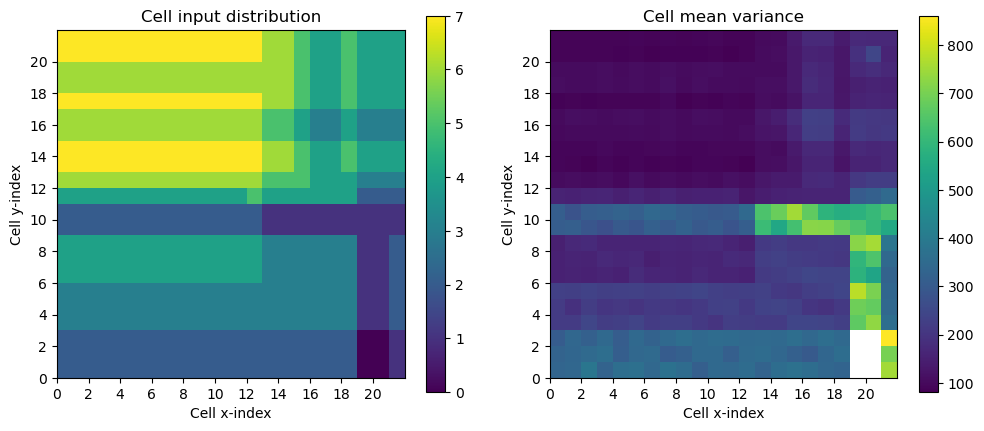

In [12]:
fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
plt.tight_layout()

input_distrib = ax1.pcolormesh(inputs_list, shading='auto', vmin=inputs_list.min(), vmax=inputs_list.max())
ax1.set_title("Cell input distribution")
ax1.set_xlabel("Cell x-index")
ax1.set_ylabel("Cell y-index")
ax1.set_aspect('equal')
ax1.set_xticks(np.arange(0, 21, 2))
ax1.set_yticks(np.arange(0, 21, 2))
fig.colorbar(input_distrib, ax=ax1, cmap='viridis', shrink=0.4)

var_distrib = ax2.pcolormesh(mask_mean_var_list, 
               shading='auto', 
               vmin=ma.min(mask_mean_var_list[np.isfinite(mask_mean_var_list)]), 
               vmax=ma.max(mask_mean_var_list[np.isfinite(mask_mean_var_list)]),)
ax2.set_title("Cell mean variance")
ax2.set_xlabel("Cell x-index")
ax2.set_ylabel("Cell y-index")
ax2.set_aspect('equal')
ax2.set_xticks(np.arange(0, 21, 2))
ax2.set_yticks(np.arange(0, 21, 2))
fig.colorbar(var_distrib, ax=ax2, cmap='viridis', shrink=0.4)

plt.show()

Patterns in variance values tend to follow pattern in number of inputs. Let's look at this relationship a bit more closely.

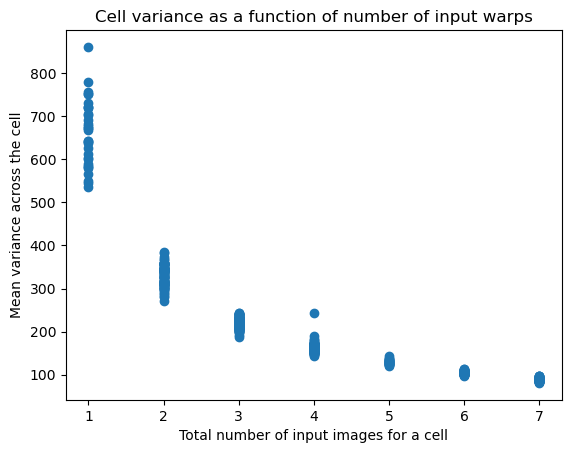

In [13]:
inputs_flat = inputs_list.flatten()
median_var_flat = mask_mean_var_list.flatten()

plt.scatter(inputs_flat, mask_mean_var_list)
plt.xlabel("Total number of input images for a cell")
plt.ylabel("Mean variance across the cell")
plt.title("Cell variance as a function of number of input warps")
plt.show()

Can clearly see now that more input images improve the variance, as expected.

### Verify weighted mean of the variance

Verify that the weighted mean of the variance from the input warps is ~1, since `_compute_weight` is approximately the inverse of the variance plane (though it ignores high variance areas when calculating the mean variance, i.e. stars)

Only concerned with a single cell at a time for now.

In [14]:
accTask = AssembleCellCoaddTask()

var_test_cell = coadd.cells[Index2D(x=21,y=21)]

bbox = var_test_cell.outer.bbox
var_warp_coadded = np.zeros([bbox.getHeight(),bbox.getWidth()])

# check if cell is empty
cell_list_test = [not (var_test_cell.identifiers.cell==cell) for cell in cell_list_filled]
assert not np.all(cell_list_test), "Cell is empty"

for warp_visit in visits:
    
    warp = butler.get('deepCoadd_directWarp',
                       collections = collection,
                       instrument='HSC',
                       skymap = 'hsc_rings_cells_v1',
                       tract = 9813,
                       patch = patch,
                       visit = warp_visit)
  
    # check if cell uses warp, skip cell if not
    cell_inputs = list(var_test_cell.inputs)
    cell_visits = [input.visit for input in cell_inputs]
    if not (np.isin(warp_visit, cell_visits)):
        continue
    
    # get a cutout of the warp that matches this cell boundary
    masked_im = warp[bbox].getMaskedImage()

    # compute weights from _compute_weight statistic
    computed_weight = accTask._compute_weight(masked_im, statsCtrl)
    
    # get the weighted var for this cell for a single pixel
    im_var_array = masked_im.variance.array

    # get the weighted array of the variance
    weighted_var_array = computed_weight * masked_im.variance.array
    var_warp_coadded += weighted_var_array

    del warp
    gc.collect()

var_warp_coadded = ma.masked_invalid(np.array(var_warp_coadded)) / len(var_test_cell.inputs)

Plot the weighted sum from the input warps to the variance of that pixel to the cell.

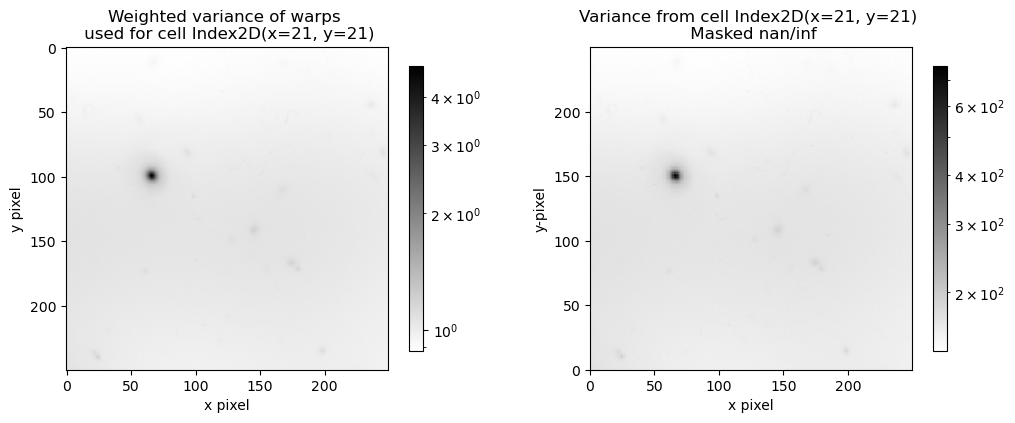

In [15]:
# get the variance from test cell
cell_var = ma.masked_invalid(np.array(var_test_cell.outer.variance.array))

fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(10,12))
plt.tight_layout()
plt.subplots_adjust(wspace=0.3)

warp_var_distrib = ax1.imshow(np.flip(var_warp_coadded, axis=0), 
                                cmap='gray_r',
                                norm='log',)

ax1.set_title(f"Weighted variance of warps \n used for cell {var_test_cell.identifiers.cell}")
ax1.set_xlabel("x pixel")
ax1.set_ylabel("y pixel")
ax1.set_aspect('equal')
ax1.set_xticks(np.arange(0, 249, 50))
ax1.set_yticks(np.arange(0, 249, 50))

fig.colorbar(warp_var_distrib, ax=ax1, cmap='viridis', shrink=0.25)

cell_var_all = ax2.pcolormesh(cell_var, 
                               cmap='gray_r',
                               norm='log',)
ax2.set_title(f"Variance from cell {var_test_cell.identifiers.cell} \n Masked nan/inf")
ax2.set_xlabel("x pixel")
ax2.set_ylabel("y-pixel")
ax2.set_aspect('equal')
ax2.set_xticks(np.arange(0, 249, 50))
ax2.set_yticks(np.arange(0, 249, 50))

fig.colorbar(cell_var_all, ax=ax2, cmap='viridis', shrink=0.25)

plt.show()

Majority of pixels in the weighted warp are ~1, which is expected as the `_compute_weight` function is approximately the inverse of the variance plane. The pixel values are not exactly one, however, since `_compute_weight` applies a single weight value to all pixels. The variance from the cell is moreso an example of what the varinace plane looks like across a single cell.

#### Mask bit masks in cell variance plane

Not necessarily related to the variance, but this is rather a rough demo on using the mask plane to ignore specific features, like cosmic rays.

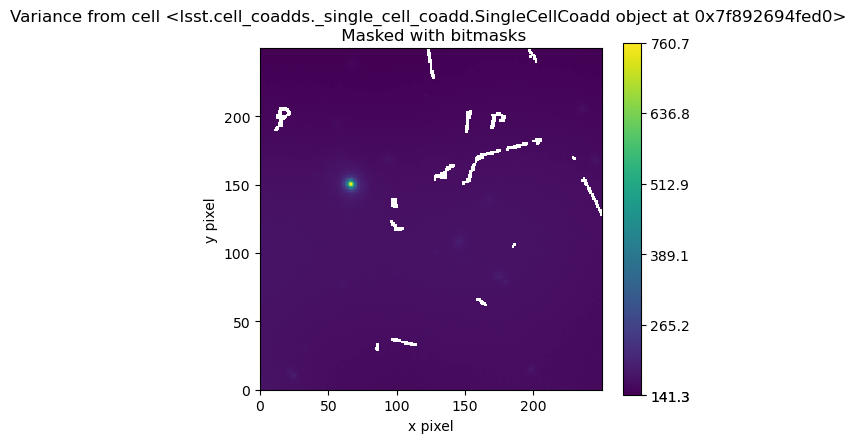

In [16]:
test_mask = var_test_cell.outer.mask

# create masks (elements where the mask occurs are set to True)
var_mask_intrp = np.where(np.bitwise_and(test_mask.array, test_mask.getPlaneBitMask("INTRP")), True, False)
var_mask_sat = np.where(np.bitwise_and(test_mask.array, test_mask.getPlaneBitMask("SAT")), True, False)
var_mask_streak = np.where(np.bitwise_and(test_mask.array, test_mask.getPlaneBitMask("STREAK")), True, False)
var_mask_suspect = np.where(np.bitwise_and(test_mask.array, test_mask.getPlaneBitMask("SUSPECT")), True, False)
var_mask_cr = np.where(np.bitwise_and(test_mask.array, test_mask.getPlaneBitMask("CR")), True, False)
var_mask_nan = np.where(np.isfinite(var_test_cell.outer.variance.array), False, True)

# combine masks into a single mask. Any mask occuring will mask that element
all_mask = np.logical_or.reduce((var_mask_cr, var_mask_sat, var_mask_streak, var_mask_suspect, var_mask_cr, var_mask_nan))

# apply the mask to the variance plane of the cell
var_add_masks = ma.masked_array(var_test_cell.outer.variance.array, mask=all_mask)

fig,(ax1) = plt.subplots(1, 1, figsize=(5,5))
plt.tight_layout()
plt.subplots_adjust(wspace=0.3)

cell_add_masks = ax1.pcolormesh(var_add_masks, 
                               shading='auto', 
                               vmin=var_add_masks.min(), 
                               vmax=var_add_masks.max(),)

ax1.set_title(f"Variance from cell {var_test_cell} \n Masked with bitmasks")
ax1.set_xlabel("x pixel")
ax1.set_ylabel("y pixel")
ax1.set_aspect('equal')
ax1.set_xticks(np.arange(0, 249, 50))
ax1.set_yticks(np.arange(0, 249, 50))
ticks1 = var_add_masks.min()
ticks1 = np.append(ticks1, np.linspace(var_add_masks.min(), var_add_masks.max(), 5, endpoint=False))
ticks1 = np.append(ticks1, var_add_masks.max())

fig.colorbar(cell_add_masks, ax=ax1, cmap='viridis', shrink=0.8, ticks=ticks1)
plt.show()

## Tract Level Input Function

We saw earlier that the variance decreases as the number of input warps to a cell increases. Let's see what this relationship looks like at a slightly larger scale, at the tract level.

In [17]:
tract = 9813

patches = []
# look for deepCoaddCell objects rather than input warps
# since some patches may fail and not produce coadds, but still have all warps in collection
for ref in butler.registry.queryDatasets('deepCoaddCell',
                                         physical_filter='HSC-I',
                                         collections=collection,
                                         instrument='HSC',
                                         skymap = 'hsc_rings_cells_v1',
                                         where=f'tract={tract}'):
    patches.append(ref.dataId.get('patch'))
patches = np.unique(patches)

In [18]:
cell_count = 0
for patch in patches:
    coadd = butler.get('deepCoaddCell', 
                         collections=collection, 
                         instrument='HSC', 
                         skymap = 'hsc_rings_cells_v1', 
                         tract = tract, 
                         patch=patch,
                         band='i',)

    cells = len(list(coadd.cells.keys())) # get number of non-empty cells
    cell_count += cells
    del coadd
    gc.collect()
print("Number of cells: ", cell_count)

Number of cells:  7657


In [19]:
# collect cell info
cell_df = pd.DataFrame()
inputs_list = []
mean_var_list = []
center_ra = []
center_dec = []

for patch in patches:
    
    coadd = butler.get('deepCoaddCell', 
                     collections=collection, 
                     instrument='HSC', 
                     skymap = 'hsc_rings_cells_v1', 
                     tract = 9813, 
                     patch=patch,
                     band='i',)

    wcs = coadd.wcs
    
    cell_list = list(coadd.cells.keys()) # skips indices that are empty

    # for each cell in cell_list:
    for index, cell_index in enumerate(cell_list):

        cell = coadd.cells[cell_index]

        inputs_list.append(cell.visit_count)

        cell_center = cell.outer.bbox.getCenter()
        cell_center_coord = wcs.pixelToSky(cell_center)
        center_ra.append(cell_center_coord[0].asDegrees())
        center_dec.append(cell_center_coord[1].asDegrees())

        var_array = cell.inner.variance.array
    
        # mask cells with only inf/-inf variance
        if (len(var_array[np.isfinite(var_array)]) == 0):
            mean_var_list.append(np.nan) # nans will be dropped later in dataframe
            continue
        
        mean_var = np.nanmean(var_array[np.isfinite(var_array)])
        mean_var_list.append(mean_var)

    del coadd

cell_df["inputs"] = inputs_list
cell_df["variance"] = mean_var_list
cell_df["center_ra"] = center_ra
cell_df["center_dec"] = center_dec

# drop cells with only nan variance
cell_df = cell_df[cell_df['variance'].notna()]

# drop duplicate cells from patch overlap
cell_df = cell_df.drop_duplicates(subset=['center_ra', 'center_dec'])

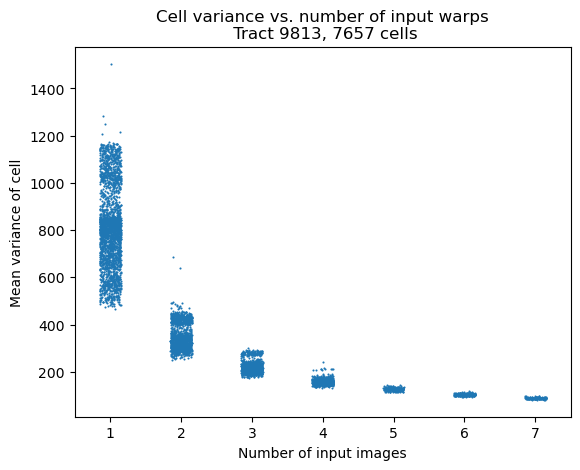

In [20]:
sns.stripplot(data=cell_df, x="inputs", y="variance", jitter=0.15, size=1.5)
plt.xlabel("Number of input images")
plt.ylabel("Mean variance of cell")
plt.title(f"Cell variance vs. number of input warps\n Tract 9813, {cell_count} cells")
plt.savefig('image_outputs/variance-vs-inputs.png', bbox_inches='tight')
plt.show()